
# Homework 3 for Topic modeling module

In [ ]:
import os
import sys
os.environ["ARTM_SHARED_LIBRARY"] = 'D:/Makarov/BigARTM/bin/artm.dll'
sys.path.append('D:/Makarov/BigARTM/python')

import artm

In [ ]:
import pandas as pd
import numpy as np
import itertools
import re
import string
import shutil

from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from spellchecker import SpellChecker

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn import metrics

from gensim import corpora
from gensim.models import Phrases, LsiModel, LdaModel
from gensim.corpora.dictionary import Dictionary as GensimDict
from gensim.models.coherencemodel import CoherenceModel

from wordcloud import WordCloud
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [ ]:
%%javascript
(function(){
    var startTime;
    $([Jupyter.events]).on('execute.CodeCell', function(event, target)
    {
        startTime = performance.now();
    });
    $([Jupyter.events]).on('finished_iopub.Kernel', function(event, target)
    {
        var endTime = performance.now();

        if(endTime - startTime > 5 * 1000)
        {
            var audio = new Audio('https://www.soundjay.com/button/beep-30b.mp3');
            audio.play();    
        }
    });
})()

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## First dataset

### Read data and EDA

In [ ]:
data = pd.read_csv('./data/recipes.csv')
pd.options.display.max_columns = 30
data.head()

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
0,Пошаговые рецепты/Заготовки/Грузинская кухня,Капуста по‑грузински,13411:Вода\n13410:Сахар\n13421:Соль\n14585:Укс...,30 минут + 5 суток,"0. Смешать воду, сахар и соль, довести до кипе...",zagotovki,91 ккал,"2,7 грамм","0,2 грамм","18,6 грамм"
1,Пошаговые рецепты/Заготовки/Веганская еда,Арбузный мед,14287:Арбуз,5 часов,"0. Арбуз помыть, обсушить и разрезать на четыр...",zagotovki,350 ккал,"8,4 грамм","1,4 грамм","81,2 грамм"
2,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Маринованные опята,14584:Опята\n13422:Уксус\n13421:Соль\n13460:Ла...,40 минут + 1 сутки,0. Промытые опята бросить в кипящую воду и вар...,zagotovki,36 ккал,"2,4 грамм","1,4 грамм","4,6 грамм"
3,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Соленые огурцы по бабушкиному рецепту,15137:Огурцы\n13421:Соль\n14786:Листья черной ...,30 минут + 20 суток,0. Огурцы лучше брать небольшие и плотные. Дли...,zagotovki,142 ккал,"7,4 грамм",1 грамм,"24,9 грамм"
4,Пошаговые рецепты/Заготовки/Варенье,Клубничное варенье с черным перцем,13494:Клубника\n13410:Сахар\n13427:Лимон\n1373...,1 час,0. Вымыть клубнику под проточной водой. Лучше ...,zagotovki,4460 ккал,12 грамм,"4,7 грамм","1083,9 грамм"


In [ ]:
data.describe()

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
count,38615,38610,38615,38615,38613,38615,38615,38615,38615,38615
unique,8178,38398,38320,630,38487,13,2599,1549,1944,2457
top,Основные блюда,Коктейль,13410:Сахар\n13447:Яблоко\n13411:Вода,30 минут,0. Смешайте все ингредиенты в блендере до одно...,vypechka-deserty,223 ккал,"4,9 грамм","0,1 грамм","12,5 грамм"
freq,1064,18,5,7695,3,9412,79,211,397,102


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38615 entries, 0 to 38614
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          38615 non-null  object
 1   title         38610 non-null  object
 2   ingredients   38615 non-null  object
 3   time          38615 non-null  object
 4   steps         38613 non-null  object
 5   category      38615 non-null  object
 6   Калорийность  38615 non-null  object
 7   Белки         38615 non-null  object
 8   Жиры          38615 non-null  object
 9   Углеводы      38615 non-null  object
dtypes: object(10)
memory usage: 2.9+ MB


In [ ]:
data[np.any(data.isna(), axis=1)]

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
2180,Выпечка и десерты/Европейская кухня/Шоколадный...,NaN,14339:Коричневый сахар\n13453:Молоко\n13412:Сл...,2 часа 30 минут + 1 час 30 минут,"0. Смешать сахар, масло \n1. Поставьте духовой...",vypechka-deserty,8477 ккал,"126,5 грамм","502,7 грамм","869,3 грамм"
2974,Выпечка и десерты/Европейская кухня/Печенье,NaN,13458:Пшеничная мука\n13421:Соль\n13412:Сливоч...,30 минут,0. Просеять муку и добавить соль.\n1. В другой...,vypechka-deserty,703 ккал,"6,3 грамм","47,2 грамм","64,3 грамм"
8784,Выпечка и десерты/Европейская кухня/Чизкейк,Карамельный чизкейк со сливочным топпингом,14110:Песочное печенье\n13423:Растительное мас...,2 часа,NaN,vypechka-deserty,926 ккал,"11,4 грамм","67,9 грамм","59,3 грамм"
32337,Закуски/Европейская кухня/Жульен,Жюльен с пореем и грибами в соусе бешамель,13509:Шампиньоны\n13430:Чеснок\n13462:Лук-поре...,45 минут,NaN,zakuski,338 ккал,"9,6 грамм","28,7 грамм","11,4 грамм"
37173,Напитки/Европейская кухня/Коктейли с ромом,NaN,14366:Белый ром\n14196:Красный портвейн\n13843...,5 минут,0. Бокал на 250 мл заполнить льдом\n1. Все инг...,napitki,154 ккал,"0,2 грамм",0 грамм,"10,3 грамм"
37197,Напитки,NaN,16304:Ром «Бакарди»\n15914:Сироп маракуйи\n151...,10 минут,0. В бокал,napitki,205 ккал,"2,8 грамм","0,4 грамм","19,6 грамм"
37239,Напитки/Европейская кухня/Коктейли с вином,NaN,14120:Сахарный сироп\n13494:Клубника\n13427:Ли...,5 минут,0. Разложить клубнику по стаканам. Добавить по...,napitki,170 ккал,"0,7 грамм","0,2 грамм","19,8 грамм"


In [ ]:
data[data['title'].isna()]

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
2180,Выпечка и десерты/Европейская кухня/Шоколадный...,NaN,14339:Коричневый сахар\n13453:Молоко\n13412:Сл...,2 часа 30 минут + 1 час 30 минут,"0. Смешать сахар, масло \n1. Поставьте духовой...",vypechka-deserty,8477 ккал,"126,5 грамм","502,7 грамм","869,3 грамм"
2974,Выпечка и десерты/Европейская кухня/Печенье,NaN,13458:Пшеничная мука\n13421:Соль\n13412:Сливоч...,30 минут,0. Просеять муку и добавить соль.\n1. В другой...,vypechka-deserty,703 ккал,"6,3 грамм","47,2 грамм","64,3 грамм"
37173,Напитки/Европейская кухня/Коктейли с ромом,NaN,14366:Белый ром\n14196:Красный портвейн\n13843...,5 минут,0. Бокал на 250 мл заполнить льдом\n1. Все инг...,napitki,154 ккал,"0,2 грамм",0 грамм,"10,3 грамм"
37197,Напитки,NaN,16304:Ром «Бакарди»\n15914:Сироп маракуйи\n151...,10 минут,0. В бокал,napitki,205 ккал,"2,8 грамм","0,4 грамм","19,6 грамм"
37239,Напитки/Европейская кухня/Коктейли с вином,NaN,14120:Сахарный сироп\n13494:Клубника\n13427:Ли...,5 минут,0. Разложить клубнику по стаканам. Добавить по...,napitki,170 ккал,"0,7 грамм","0,2 грамм","19,8 грамм"


In [ ]:
data[data['steps'].isna()]

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
8784,Выпечка и десерты/Европейская кухня/Чизкейк,Карамельный чизкейк со сливочным топпингом,14110:Песочное печенье\n13423:Растительное мас...,2 часа,NaN,vypechka-deserty,926 ккал,"11,4 грамм","67,9 грамм","59,3 грамм"
32337,Закуски/Европейская кухня/Жульен,Жюльен с пореем и грибами в соусе бешамель,13509:Шампиньоны\n13430:Чеснок\n13462:Лук-поре...,45 минут,NaN,zakuski,338 ккал,"9,6 грамм","28,7 грамм","11,4 грамм"


In [ ]:
data.category.value_counts()

vypechka-deserty    9412
osnovnye-blyuda     9291
zakuski             5204
salaty              4032
supy                2763
zavtraki            1971
napitki             1945
pasta-picca         1787
sousy-marinady      1288
sendvichi            566
rizotto              245
bulony                79
zagotovki             32
Name: category, dtype: int64

In [ ]:
data.dropna(axis=0, inplace=True)

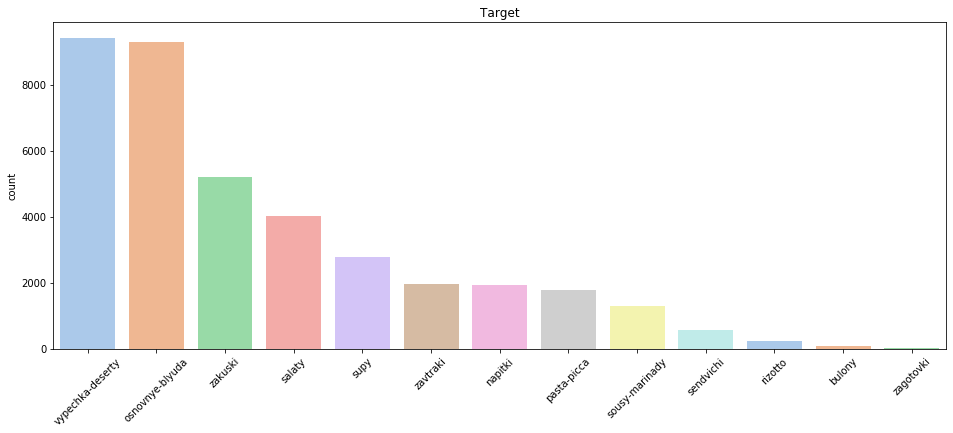

In [ ]:
plt.figure(figsize=(16, 6))
t = sns.countplot(x='category', palette='pastel', data=data, order=data['category'].value_counts().index)
t.set(xlabel='', title='Target')
t.set_xticklabels(t.get_xticklabels(), rotation=45);

In [ ]:
data.tags[0]

'Пошаговые рецепты/Заготовки/Грузинская кухня'

In [ ]:
data.title[0]

'Капуста по‑грузински'

In [ ]:
data.ingredients[0]

'13411:Вода\n13410:Сахар\n13421:Соль\n14585:Уксус 9%-ный\n13436:Белокочанная капуста\n13438:Свекла\n13449:Морковь\n13506:Перец чили\n13430:Чеснок\n13737:Черный перец горошком'

----

### Clean text

In [ ]:
russian_stopwords = stopwords.words("russian")  # собираем стоп слова
regex = re.compile('[%s]' % re.escape(string.punctuation))  # компилим regexp выражение
stemmer = SnowballStemmer("russian")  # инициализируем стэмминг

In [ ]:
russian_stopwords.extend(['эт', 'это', 'эта', 'эту', 'этого', 'этих',
                          'так', 'такой', 'такая', 'такие', 'таких',
                          'одн', 'один', 'одна', 'одну', 'одни',
                          'другой', 'другая', 'другие', 'других',
                          'котор', 'который', 'которая', 'которые', 'которых',
                          'сво', 'свой', 'свои', 'своих', 'своего', 'свою',
                          'наш', 'нам', 'ваш', 'их',
                          'дан', 'данный', 'данная', 'данное', 'данную',
                          'сам', 'самый', 'самая', 'самое', 'самые', 'самую',
                          'вс', 'всё', 'все', 'вся', 'ещ', 'ещё', 'еще'
                          'работ', 'работа', 'работу', 'работы', 'по'])

In [ ]:
def preprocessing(text):
    text = regex.sub('', text)  # удаляем пунктуацию
    text = re.sub(r"[^а-яА-Я']", ' ', text)
    text = [token for token in text.split() if token not in russian_stopwords]  # удаляем стоп слова
    text = [stemmer.stem(token) for token in text]  # выполняем стэмминг
    text = [token for token in text if token and token not in russian_stopwords]  # удаляем пустые токены
    return ' '.join(text)

# Пробуем  вызвать  и посмотреть на результат
preprocessing("я вы он и мы, футбол, пиво, люблю! Extended")

'футбол пив любл'

In [ ]:
data['title'] = data['title'].apply(lambda x: preprocessing(x))

----

#### Number of topics

In [ ]:
num_of_topics = 13

----

### Models

In [ ]:
cv = CountVectorizer(max_features=1000)
n_wd = np.array(cv.fit_transform(data['title'].values.astype('U')).todense()).T
vocabulary = cv.get_feature_names()

In [ ]:
target_folder = 'data_dict'

In [ ]:
shutil.rmtree(target_folder, ignore_errors=True)

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=n_wd,
                                        target_folder=target_folder,
                                        vocabulary=vocabulary)

In [ ]:
dictionary = artm.Dictionary()

lda_model = artm.LDA(num_topics=num_of_topics, alpha=0.01, beta=0.001, cache_theta=True,
                     dictionary=batch_vectorizer.dictionary)

plsa_model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_of_topics)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True)

artm_model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_of_topics)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True)

In [ ]:
lda_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [ ]:
print('Mean perplexity:', np.mean(lda_model.perplexity_value))

Mean perplexity: 192.8090850830078


In [ ]:
lda_model_topics = []
top_tokens = lda_model.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
    print('topic_{0}: {1}'.format(i, token_list))
    lda_model_topics.append(token_list)

topic_0: ['куриц', 'гриб', 'бел', 'вин', 'овсян', 'индейк', 'мясн', 'груш', 'маффин', 'ризотт']
topic_1: ['орех', 'творожн', 'тест', 'грецк', 'кориц', 'слоен', 'каш', 'мед', 'изюм', 'лос']
topic_2: ['паст', 'запеканк', 'кабачк', 'сметан', 'клубник', 'спагетт', 'пест', 'чил', 'французск', 'рисов']
topic_3: ['зелен', 'торт', 'фасол', 'яблок', 'шпинат', 'масл', 'омлет', 'олад', 'закуск', 'баклажан']
topic_4: ['сыр', 'фарширова', 'сырн', 'томатн', 'быстр', 'тыквен', 'баранин', 'ананас', 'тепл', 'трав']
topic_5: ['суп', 'крем', 'коктейл', 'овощн', 'сливк', 'ягод', 'бананов', 'чечевиц', 'морск', 'нежн']
topic_6: ['помидор', 'картофел', 'авокад', 'тушен', 'грил', 'ветчин', 'огурц', 'томат', 'свеж', 'апельсин']
topic_7: ['салат', 'сливочн', 'чеснок', 'морков', 'морожен', 'заправк', 'свекл', 'сельдере', 'спец', 'руккол']
topic_8: ['печен', 'лук', 'тыкв', 'сладк', 'апельсинов', 'броккол', 'лапш', 'суппюр', 'кокосов', 'имбир']
topic_9: ['запечен', 'домашн', 'мяс', 'копчен', 'творог', 'рулет', 'цу

In [ ]:
#phi = lda_model.phi_
#theta = lda_model.get_theta()

----

In [ ]:
if not os.path.isfile(target_folder + '/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path=target_folder + '/dictionary.dict')

dictionary.load(dictionary_path=target_folder + '/dictionary.dict')

In [ ]:
plsa_model.initialize(dictionary=dictionary)
artm_model.initialize(dictionary=dictionary)

In [ ]:
plsa_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
plsa_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
plsa_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3), overwrite=True)

artm_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
artm_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
artm_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3), overwrite=True)

In [ ]:
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1), overwrite=True)
artm_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5), overwrite=True)

In [ ]:
plsa_model.num_document_passes = 1
artm_model.num_document_passes = 1

plsa_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_of_topics)
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_of_topics)

Sparsity Phi: 0.057 (PLSA) vs. 0.930 (ARTM)
Sparsity Theta: 0.002 (PLSA) vs. 0.812 (ARTM)
Kernel contrast: 0.960 (PLSA) vs. 1.000 (ARTM)
Kernel purity: 0.982 (PLSA) vs. 1.000 (ARTM)
Perplexity: 103.661 (PLSA) vs. 100.657 (ARTM)


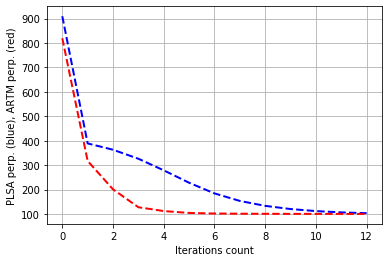

In [ ]:
def print_measures(model_plsa, model_artm):
    print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value,
        model_artm.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value,
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast,
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity,
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value,
        model_artm.score_tracker['PerplexityScore'].last_value))

    plt.plot(range(model_plsa.num_phi_updates), model_plsa.score_tracker['PerplexityScore'].value, 'b--',
             range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    
print_measures(plsa_model, artm_model)

In [ ]:
artm_model.regularizers['SparsePhi'].tau = -0.2
artm_model.regularizers['SparseTheta'].tau = -0.2
artm_model.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
plsa_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
artm_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))

In [ ]:
plsa_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.891 (PLSA) vs. 0.930 (ARTM)
Sparsity Theta: 0.696 (PLSA) vs. 0.812 (ARTM)
Kernel contrast: 0.998 (PLSA) vs. 1.000 (ARTM)
Kernel purity: 1.000 (PLSA) vs. 1.000 (ARTM)
Perplexity: 97.135 (PLSA) vs. 100.666 (ARTM)


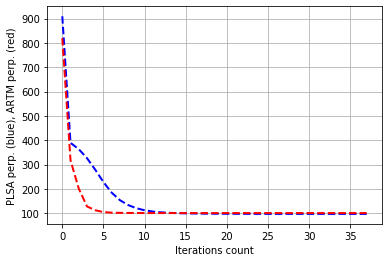

In [ ]:
print_measures(plsa_model, artm_model)

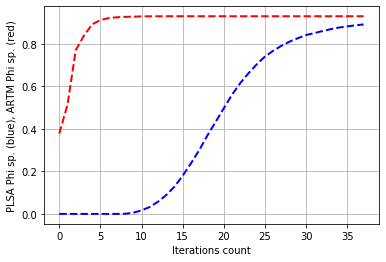

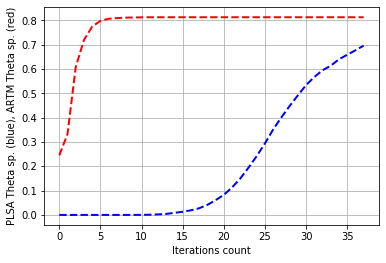

In [ ]:
plt.plot(range(plsa_model.num_phi_updates), plsa_model.score_tracker['SparsityPhiScore'].value, 'b--',
                 range(artm_model.num_phi_updates), artm_model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(plsa_model.num_phi_updates), plsa_model.score_tracker['SparsityThetaScore'].value, 'b--',
                 range(artm_model.num_phi_updates), artm_model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [ ]:
plsa_model_topics = []
for topic_name in plsa_model.topic_names:
    print('{0}: {1}'.format(topic_name, plsa_model.score_tracker['TopTokensScore'].last_tokens[topic_name]))
    plsa_model_topics.append(plsa_model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['куриц', 'гриб', 'бел', 'вин', 'овсян', 'индейк']
topic_1: ['орех', 'крем', 'творожн', 'тест', 'каш', 'грецк']
topic_2: ['паст', 'запеканк', 'кабачк', 'сметан', 'клубник', 'спагетт']
topic_3: ['зелен', 'торт', 'яблок', 'фасол', 'шпинат', 'масл']
topic_4: ['сыр', 'жарен', 'фарширова', 'авокад', 'сырн', 'томатн']
topic_5: ['суп', 'перц', 'коктейл', 'овощн', 'бекон', 'сливк']
topic_6: ['помидор', 'картофел', 'тушен', 'грил', 'ветчин', 'огурц']
topic_7: ['салат', 'сливочн', 'чеснок', 'слоен', 'морожен', 'заправк']
topic_8: ['печен', 'лук', 'тыкв', 'сладк', 'апельсинов', 'смуз']
topic_9: ['запечен', 'домашн', 'мяс', 'копчен', 'творог', 'молок']
topic_10: ['креветк', 'яйц', 'морков', 'пицц', 'тыквен', 'мят']
topic_11: ['пирог', 'капуст', 'шоколадн', 'картофельн', 'кекс', 'маринова']
topic_12: ['соус', 'курин', 'овощ', 'лимон', 'рис', 'красн']


In [ ]:
artm_model_topics = []
for topic_name in artm_model.topic_names:
    print('{0}: {1}'.format(topic_name, artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name]))
    artm_model_topics.append(artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['бел', 'вин', 'фил', 'овсян', 'индейк', 'мясн']
topic_1: ['крем', 'творожн', 'тест', 'каш', 'грецк', 'кориц']
topic_2: ['паст', 'запеканк', 'кабачк', 'клубник', 'спагетт', 'чил']
topic_3: ['торт', 'фасол', 'шпинат', 'масл', 'омлет', 'олад']
topic_4: ['авокад', 'сырн', 'томатн', 'быстр', 'тыквен', 'суппюр']
topic_5: ['красн', 'коктейл', 'овощн', 'бекон', 'яблочн', 'смуз']
topic_6: ['тушен', 'грил', 'ветчин', 'огурц', 'томат', 'свеж']
topic_7: ['сливочн', 'чеснок', 'слоен', 'морожен', 'заправк', 'маринад']
topic_8: ['лук', 'тыкв', 'сладк', 'апельсинов', 'лапш', 'изюм']
topic_9: ['домашн', 'мяс', 'копчен', 'творог', 'молок', 'цукин']
topic_10: ['креветк', 'морков', 'пицц', 'мят', 'тунц', 'черн']
topic_11: ['картофельн', 'маринова', 'шоколад', 'свинин', 'котлет', 'шампиньон']
topic_12: ['лимон', 'рис', 'говядин', 'кекс', 'рыб', 'грудк']


----

### Scores

In [ ]:
text_clean = []
for index, row in data[['title']].iterrows():
    text_clean.append(row['title'].split())

bigram = Phrases(text_clean)  # Создаем биграммы на основе корпуса
trigram = Phrases(bigram[text_clean])  # Создаем триграммы на основе корпуса

for idx in range(len(text_clean)):
    for token in bigram[text_clean[idx]]:
        if '_' in token:
            # Токен это би грамма, добавим в документ.
            text_clean[idx].append(token)
    for token in trigram[text_clean[idx]]:
        if '_' in token:
            # Токен это три грамма, добавим в документ.
            text_clean[idx].append(token)

In [ ]:
def convert_words_to_tokens(dictionary, list_of_topics):
    topics = []
    for topic in list_of_topics:
        topic_list = []
        for word in topic:
            if word in dictionary.values():
                topic_list.append(list(dictionary.values()).index(word))
        topics.append(topic_list)
    return topics

In [ ]:
def model_evaluation(model_name, text, topics, dictionary):
    uci_score = CoherenceModel(topics=convert_words_to_tokens(dictionary, topics),
                               texts=text, dictionary=dictionary, coherence='c_uci').get_coherence()
    umass_score = CoherenceModel(topics=convert_words_to_tokens(dictionary, topics),
                                 texts=text, dictionary=dictionary, coherence='u_mass').get_coherence()
    print('{} Scores:'.format(model_name))
    print('UCI: {:.2f}'.format(uci_score))
    print('UMass: {:.2f}'.format(umass_score))

In [ ]:
gen_dictionary = GensimDict(text_clean)
#gen_dictionary.filter_extremes(no_below=10, no_above=0.1)
corpus = [gen_dictionary.doc2bow(doc) for doc in text_clean]

In [ ]:
#list(gen_dictionary.values())[:20]

In [ ]:
#convert_words_to_tokens(gen_dictionary, artm_model_topics)

In [ ]:
lda_model_topics

[['куриц',
  'гриб',
  'бел',
  'вин',
  'овсян',
  'индейк',
  'мясн',
  'груш',
  'маффин',
  'ризотт'],
 ['орех',
  'творожн',
  'тест',
  'грецк',
  'кориц',
  'слоен',
  'каш',
  'мед',
  'изюм',
  'лос'],
 ['паст',
  'запеканк',
  'кабачк',
  'сметан',
  'клубник',
  'спагетт',
  'пест',
  'чил',
  'французск',
  'рисов'],
 ['зелен',
  'торт',
  'фасол',
  'яблок',
  'шпинат',
  'масл',
  'омлет',
  'олад',
  'закуск',
  'баклажан'],
 ['сыр',
  'фарширова',
  'сырн',
  'томатн',
  'быстр',
  'тыквен',
  'баранин',
  'ананас',
  'тепл',
  'трав'],
 ['суп',
  'крем',
  'коктейл',
  'овощн',
  'сливк',
  'ягод',
  'бананов',
  'чечевиц',
  'морск',
  'нежн'],
 ['помидор',
  'картофел',
  'авокад',
  'тушен',
  'грил',
  'ветчин',
  'огурц',
  'томат',
  'свеж',
  'апельсин'],
 ['салат',
  'сливочн',
  'чеснок',
  'морков',
  'морожен',
  'заправк',
  'свекл',
  'сельдере',
  'спец',
  'руккол'],
 ['печен',
  'лук',
  'тыкв',
  'сладк',
  'апельсинов',
  'броккол',
  'лапш',
  'суппю

In [ ]:
plsa_model_topics

[['куриц', 'гриб', 'бел', 'вин', 'овсян', 'индейк'],
 ['орех', 'крем', 'творожн', 'тест', 'каш', 'грецк'],
 ['паст', 'запеканк', 'кабачк', 'сметан', 'клубник', 'спагетт'],
 ['зелен', 'торт', 'яблок', 'фасол', 'шпинат', 'масл'],
 ['сыр', 'жарен', 'фарширова', 'авокад', 'сырн', 'томатн'],
 ['суп', 'перц', 'коктейл', 'овощн', 'бекон', 'сливк'],
 ['помидор', 'картофел', 'тушен', 'грил', 'ветчин', 'огурц'],
 ['салат', 'сливочн', 'чеснок', 'слоен', 'морожен', 'заправк'],
 ['печен', 'лук', 'тыкв', 'сладк', 'апельсинов', 'смуз'],
 ['запечен', 'домашн', 'мяс', 'копчен', 'творог', 'молок'],
 ['креветк', 'яйц', 'морков', 'пицц', 'тыквен', 'мят'],
 ['пирог', 'капуст', 'шоколадн', 'картофельн', 'кекс', 'маринова'],
 ['соус', 'курин', 'овощ', 'лимон', 'рис', 'красн']]

In [ ]:
artm_model_topics

[['бел', 'вин', 'фил', 'овсян', 'индейк', 'мясн'],
 ['крем', 'творожн', 'тест', 'каш', 'грецк', 'кориц'],
 ['паст', 'запеканк', 'кабачк', 'клубник', 'спагетт', 'чил'],
 ['торт', 'фасол', 'шпинат', 'масл', 'омлет', 'олад'],
 ['авокад', 'сырн', 'томатн', 'быстр', 'тыквен', 'суппюр'],
 ['красн', 'коктейл', 'овощн', 'бекон', 'яблочн', 'смуз'],
 ['тушен', 'грил', 'ветчин', 'огурц', 'томат', 'свеж'],
 ['сливочн', 'чеснок', 'слоен', 'морожен', 'заправк', 'маринад'],
 ['лук', 'тыкв', 'сладк', 'апельсинов', 'лапш', 'изюм'],
 ['домашн', 'мяс', 'копчен', 'творог', 'молок', 'цукин'],
 ['креветк', 'морков', 'пицц', 'мят', 'тунц', 'черн'],
 ['картофельн', 'маринова', 'шоколад', 'свинин', 'котлет', 'шампиньон'],
 ['лимон', 'рис', 'говядин', 'кекс', 'рыб', 'грудк']]

### LDA

In [ ]:
model_evaluation('LDA', text_clean, lda_model_topics, gen_dictionary)

LDA Scores:
UCI: -4.16
UMass: -8.75


### PLSA

In [ ]:
model_evaluation('pLSA', text_clean, plsa_model_topics, gen_dictionary)

pLSA Scores:
UCI: -3.93
UMass: -8.13


### ARTM

In [ ]:
model_evaluation('ARTM', text_clean, artm_model_topics, gen_dictionary)

ARTM Scores:
UCI: -5.48
UMass: -9.54


----

### Cloud Words Visualization

In [ ]:
def plot_cloud_words(model, topics, ncols=4, limit=20, figsize=(20,20), reverse=False):
    if reverse:
        reverse = -1
    else:
        reverse = 1

    topics = list(topics[i:i+ncols] for i in range(0, len(topics), ncols))

    fig, ax = plt.subplots(nrows=len(topics), ncols=ncols, figsize=figsize)
    for i, topic_list in enumerate(topics):
        for j, topic in enumerate(topic_list):
            coef = model.phi_[topic].values
            feature_names_list = [i[1] for i in model.phi_[topic].index]

            words_freq = np.dstack((feature_names_list, coef))
            words_freq = sorted([(i[0], reverse*float(i[1])) for i in words_freq[0]], key=lambda x: x[1])[:limit]
            words_freq = [[i[0], reverse*i[1]] for i in words_freq]
            words_freq = dict(words_freq)

            w = WordCloud(width=700, height=500, mode='RGBA', background_color='black', max_words=200).fit_words(words_freq)
            ax[i,j].set_title(topic)
            ax[i,j].imshow(w)
            ax[i,j].axis("off")
        if j+1 < ncols:
            while j+1 != ncols:
                ax[i,j+1].axis("off")
                j += 1
    plt.show()

In [ ]:
topics = plsa_model.topic_names

### LDA

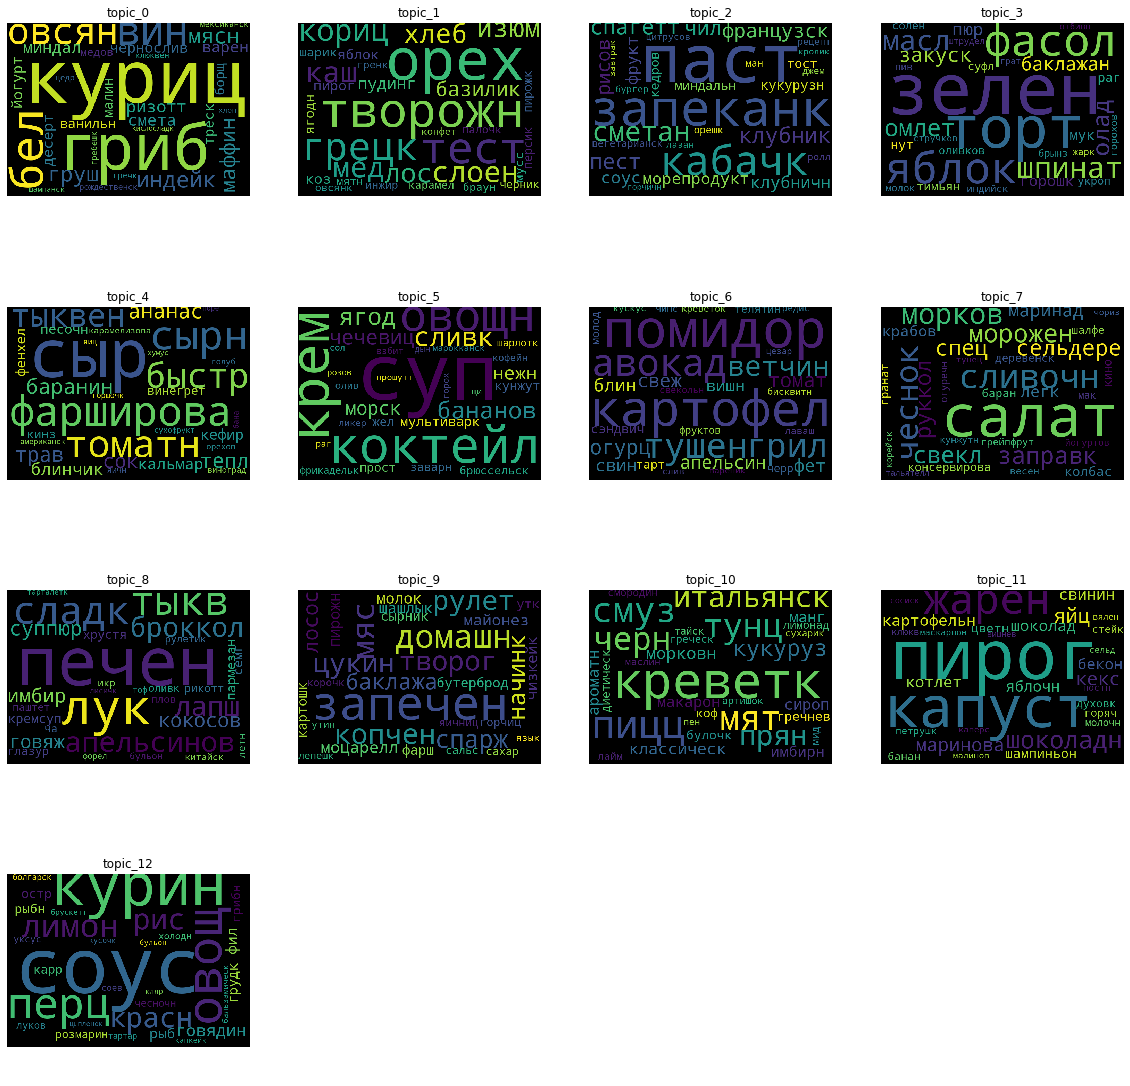

In [ ]:
plot_cloud_words(lda_model, topics, limit=30, reverse=True)

### PLSA

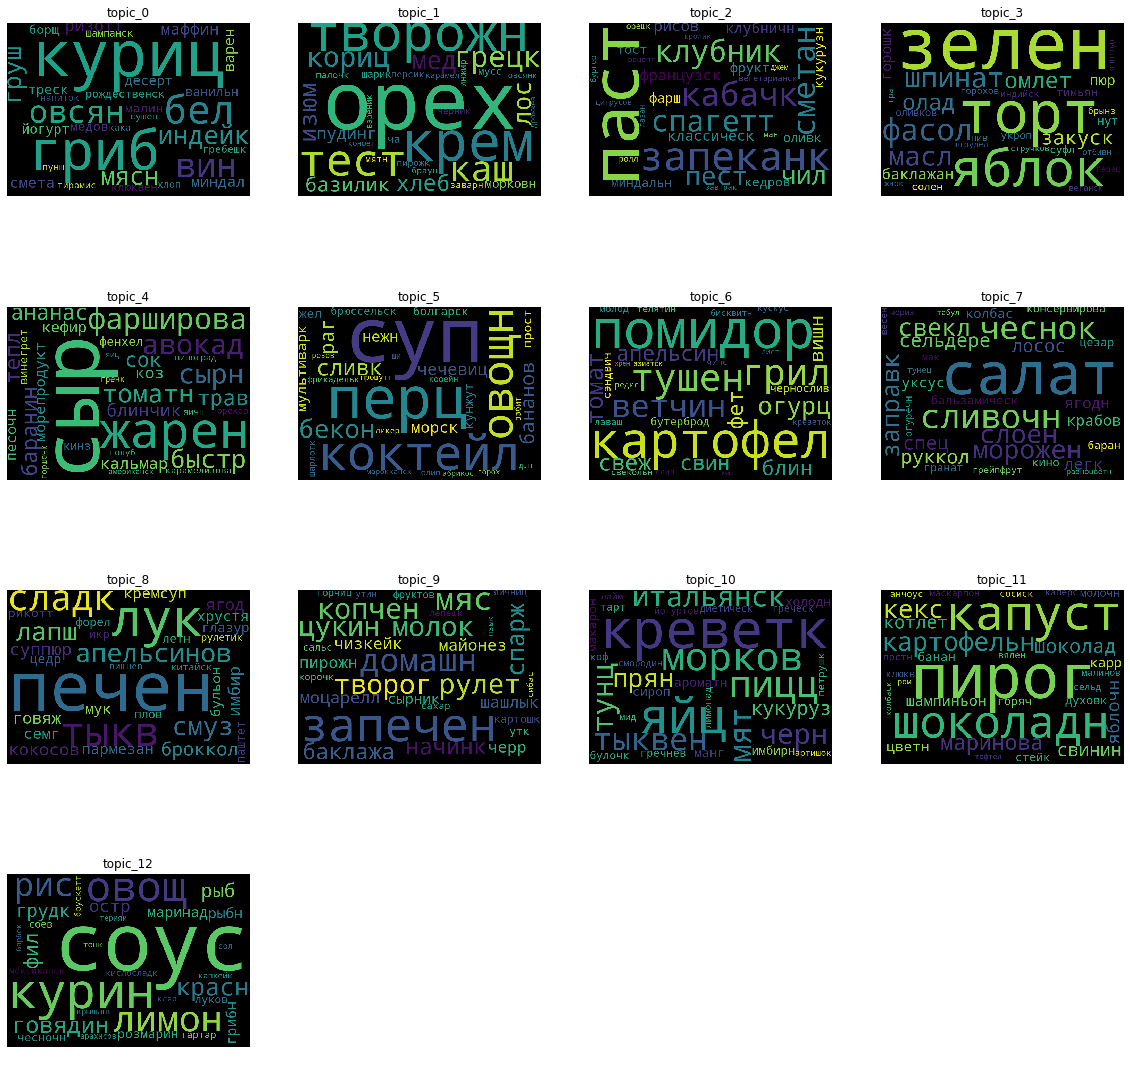

In [ ]:
plot_cloud_words(plsa_model, topics, limit=30, reverse=True)

### ARTM

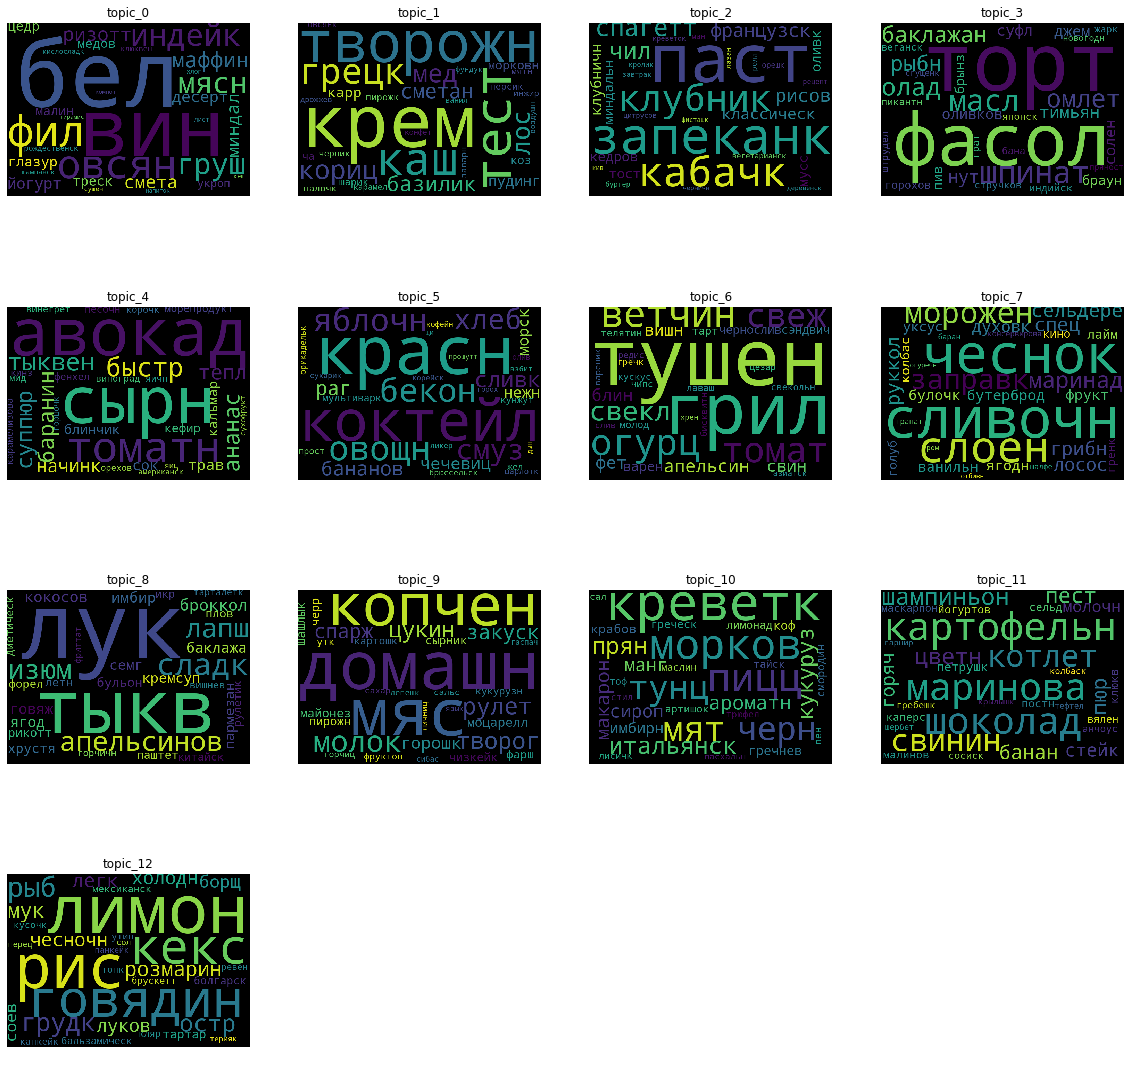

In [ ]:
plot_cloud_words(artm_model, topics, limit=30, reverse=True)

----

### t-SNE Visualization

In [ ]:
def tsne_vis(model):
    tsne_model = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=0)
    tsne_data = tsne_model.fit_transform(model.phi_)

    topic_num = np.argmax(model.phi_.values, axis=1)
    topic_num = pd.DataFrame(data=topic_num, columns=['topic'])
    
    tsne_data = pd.DataFrame(data=tsne_data, columns=['x1', 'x2'])
    tsne_data = pd.concat([tsne_data, topic_num], axis = 1)

    plt.figure(figsize=(15,15))
    sns.scatterplot(x="x1", y="x2", hue='topic', palette="Set1", data=tsne_data).set(xlabel='x_1', ylabel='x_2', title='t-SNE for {} model'.format(model.__class__.__name__))
    plt.legend(title='topics:', loc='upper right');

### LDA

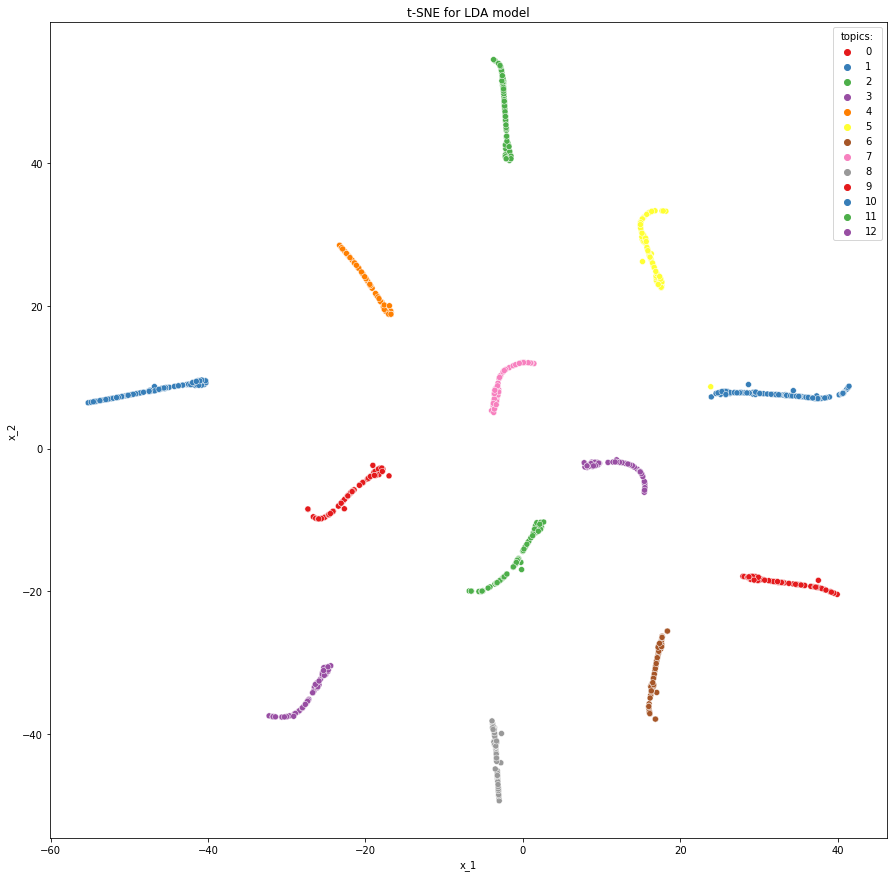

In [ ]:
tsne_vis(lda_model)

### PLSA

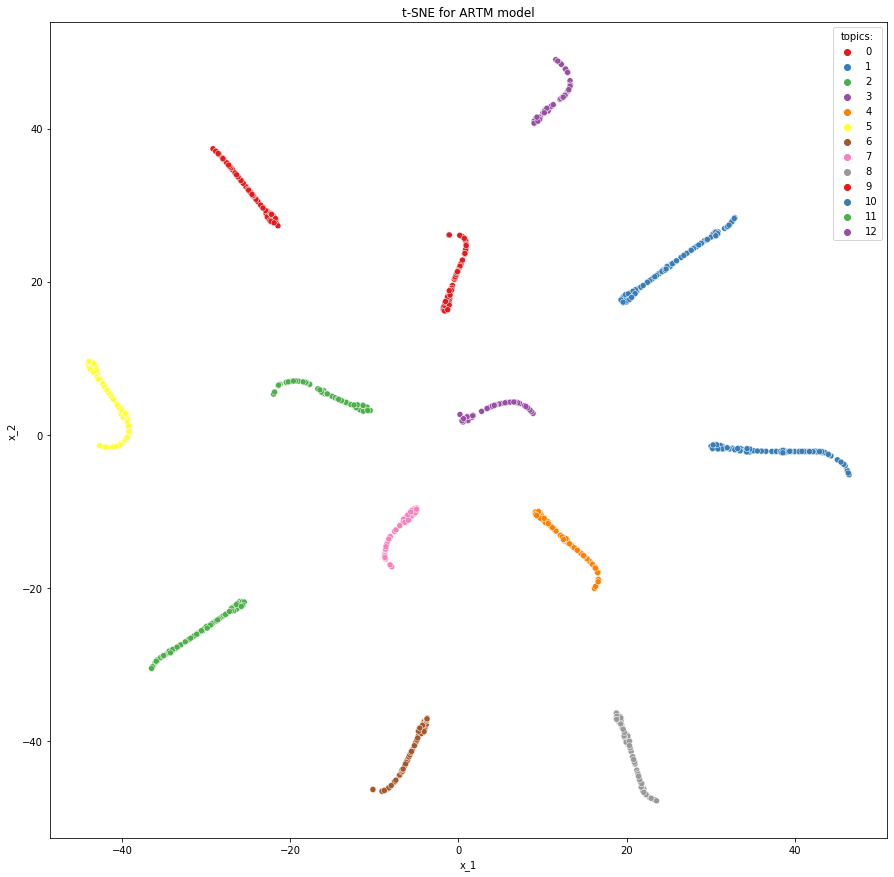

In [ ]:
tsne_vis(plsa_model)

### ARTM

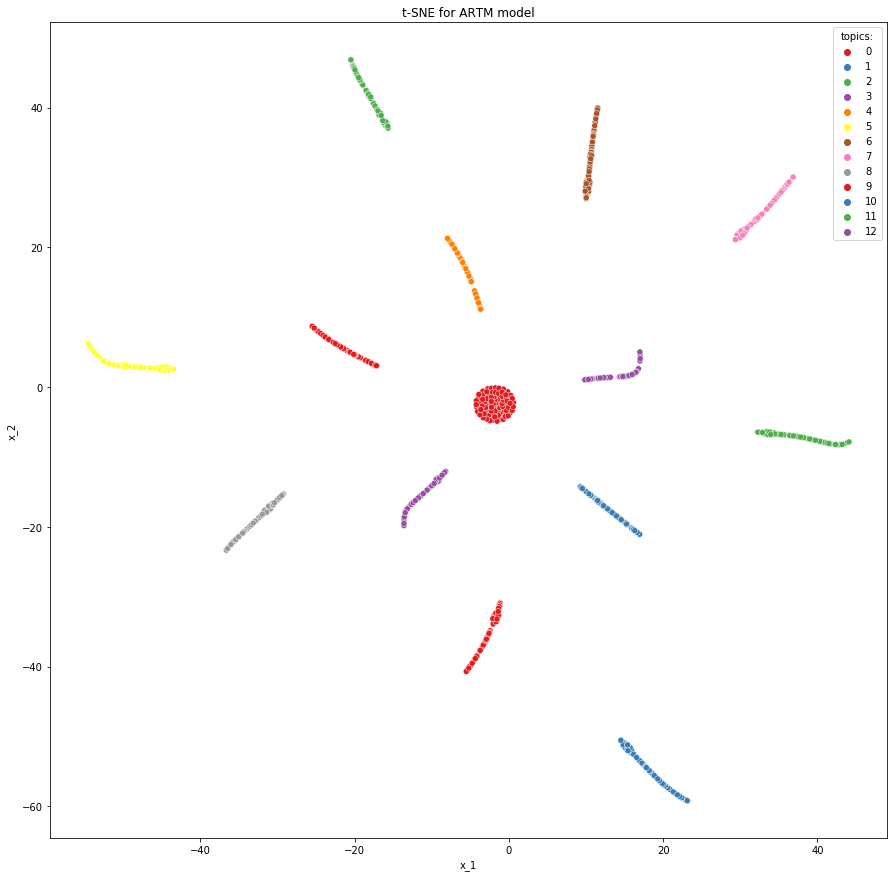

In [ ]:
tsne_vis(artm_model)

----

## Second dataset

### Read data and EDA

In [ ]:
data2 = pd.read_csv('./data/posts.csv')
data2.head()

,id,user,user_link,clean_title,clean_text,clean_tags,clean_hubs,Timestamp
0,353832,sahsAGU,https://habr.com/ru/users/sahsAGU/,обнаружение атак на active directory с помощью...,в следующем году будет 20 лет с момента создан...,"['microsoft', 'облако', 'azure', 'event', 'sec...","['информационная_безопасность', 'системное_адм...",2018-04-19 18:41:00
1,259879,kamagames,https://habr.com/ru/users/kamagames/,sdk для устройства дополненной реальности мног...,sdk для magic leap уже скорокомпания magic lea...,"['apple', 'magic_leap', 'fluent']","['разработка_мобильных_приложений', 'разработк...",2015-06-09 11:39:00
2,495328,Plarium,https://habr.com/ru/users/Plarium/,как привести в порядок историю ваших коммитов ...,публикуем перевод статьи которую мы нашли на h...,"['программирование', 'парное_программирование'...","['программирование', 'git', 'системы_управлени...",2020-04-02 16:04:00.000000
3,366155,epsonic,https://habr.com/ru/users/epsonic/,интеллектуальные терминалы epson для облачных ...,будущее электронной торговли уже здесьпрежде ч...,"['автоматизация_торговли', 'электронная_торгов...","['управление_e-commerce', 'периферия']",2015-02-10 08:56:00
4,415371,DistributedLab,https://habr.com/ru/users/DistributedLab/,конфиденциальность в криптовалютах,в рамках данной статьи мы постарались дать отв...,"['bitcoin', 'privacy', 'bitshares', 'monero']","['информационная_безопасность', 'платежные_сис...",2018-06-26 22:33:00


In [ ]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43866 entries, 0 to 43865
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           43866 non-null  int64 
 1   user         43866 non-null  object
 2   user_link    43866 non-null  object
 3   clean_title  43866 non-null  object
 4   clean_text   43861 non-null  object
 5   clean_tags   43866 non-null  object
 6   clean_hubs   43866 non-null  object
 7   Timestamp    43866 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.7+ MB


In [ ]:
data2[np.any(data2.isna(), axis=1)]

,id,user,user_link,clean_title,clean_text,clean_tags,clean_hubs,Timestamp
5151,295878,eduard_shmidt,https://habr.com/ru/users/eduard_shmidt/,система прогнозирования продаж на основе ворон...,NaN,"['продажи', 'менеджмент', 'маркетинг', 'прогно...",['управление_продажами'],2015-10-30 10:11:00
11401,287300,deniskin,https://habr.com/ru/users/deniskin/,яблокги,NaN,"['яндекс', 'блогосфера', 'поиск']",['управление_медиа'],2006-10-06 02:53:00
12883,304616,Eponesh,https://habr.com/ru/users/Eponesh/,б,NaN,[],['чулан'],2016-07-03 13:47:00
14682,453496,gjf,https://habr.com/ru/users/gjf/,с днём химика коллеги,NaN,[],['химия'],2019-05-26 13:12:00
30515,295906,eduard_shmidt,https://habr.com/ru/users/eduard_shmidt/,6 основных вопросов стратегического аудита сис...,NaN,"['продажи', 'менеджмент', 'стратегия', 'отдел_...",['управление_продажами'],2015-10-30 19:55:00


In [ ]:
data2[data2['clean_title'].isna()]

,id,user,user_link,clean_title,clean_text,clean_tags,clean_hubs,Timestamp


In [ ]:
data2[data2['clean_text'].isna()]

,id,user,user_link,clean_title,clean_text,clean_tags,clean_hubs,Timestamp
5151,295878,eduard_shmidt,https://habr.com/ru/users/eduard_shmidt/,система прогнозирования продаж на основе ворон...,NaN,"['продажи', 'менеджмент', 'маркетинг', 'прогно...",['управление_продажами'],2015-10-30 10:11:00
11401,287300,deniskin,https://habr.com/ru/users/deniskin/,яблокги,NaN,"['яндекс', 'блогосфера', 'поиск']",['управление_медиа'],2006-10-06 02:53:00
12883,304616,Eponesh,https://habr.com/ru/users/Eponesh/,б,NaN,[],['чулан'],2016-07-03 13:47:00
14682,453496,gjf,https://habr.com/ru/users/gjf/,с днём химика коллеги,NaN,[],['химия'],2019-05-26 13:12:00
30515,295906,eduard_shmidt,https://habr.com/ru/users/eduard_shmidt/,6 основных вопросов стратегического аудита сис...,NaN,"['продажи', 'менеджмент', 'стратегия', 'отдел_...",['управление_продажами'],2015-10-30 19:55:00


In [ ]:
data2.clean_hubs.value_counts()

['информационная_безопасность']                                                                                     1018
[]                                                                                                                   991
['законодательство_в_it']                                                                                            523
['научно-популярное', 'космонавтика']                                                                                397
['управление_медиа']                                                                                                 358
                                                                                                                    ... 
['javascript', 'разработка_под_ios', 'разработка_мобильных_приложений', 'reactjs']                                     1
['алгоритмы', 'разработка_под_e-commerce', 'разработка_систем_связи']                                                  1
['компьютерное_железо', 'научно-

In [ ]:
data2.dropna(axis=0, inplace=True)

In [ ]:
data2.clean_title[0]

'обнаружение атак на active directory с помощью azure'

In [ ]:
data2.clean_text[0]

'в следующем году будет 20 лет с момента создания службы каталогов active directory за это время служба обросла функционалом протоколами различными клиентами но необходимость поддерживать совместимость с рядом устаревших клиентов вынуждает иметь настройки по-умолчанию ориентированные на совместимость администраторы часто не меняют их а это создает большой риск в этой статье мы рассмотрим обнаружение атак которые могут привести к domain dominanceчто общего между между атаками на active directory и azure 1 марта 2018 года был выпущен сервис azure advanced threat protection это сервис который является облачным аналогом локального продукта advanced threat analytics в отличии от локальной версии облачная не имеет искусственных ограничений для машинного обучения и обновляется регулярно как и любые облачные сервисы с его помощью можно обнаружить как типовые атаки так и аномальное поведение пользователейдля начала работы можно зарегистрировать пробную подпискупосле первичных настроек потребует

----

### Clean text

In [ ]:
#data2['clean_title'] = data2['clean_title'].apply(lambda x: preprocessing(x))
data2['clean_text'] = data2['clean_text'].apply(lambda x: preprocessing(x))

----

### Find out optimal number of topics

In [ ]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

In [ ]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop=10, method='c_v', start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence=method)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
def plot_graph(doc_clean, start, stop, step, method):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, doc_clean,
                                                            stop, method, start, step)
    x = range(start, stop, step)
    plt.figure(figsize=(15,10))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(["coherence_values"], loc='best')
    plt.show()

In [ ]:
def preprocess_data(doc_set):
    texts = []
    for i in doc_set:
        raw = i.split()
        texts.append(raw)
    return texts

In [ ]:
clean_text = preprocess_data(data2['clean_text'].sample(n=30000, random_state=42))

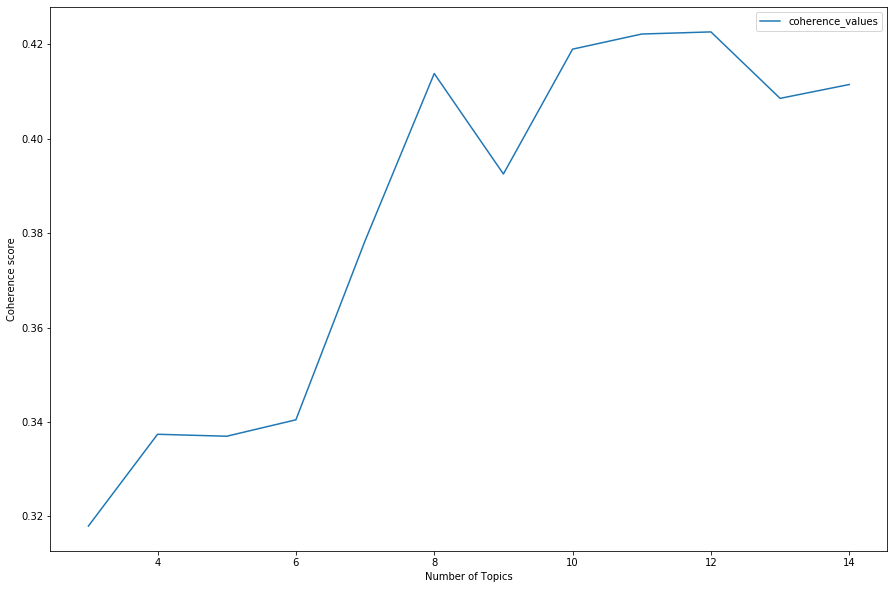

In [ ]:
plot_graph(clean_text, stop=15, step=1, start=3, method='c_v')

----

#### Number of topics

In [ ]:
num_of_topics = 12

----

### Models

In [ ]:
cv = CountVectorizer(max_features=1000)
n_wd = np.array(cv.fit_transform(data2['clean_text'].values.astype('U')).todense()).T
vocabulary = cv.get_feature_names()

In [ ]:
target_folder = 'data2_dict'

In [ ]:
shutil.rmtree(target_folder, ignore_errors=True)

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                        n_wd=n_wd,
                                        target_folder=target_folder,
                                        vocabulary=vocabulary)

In [ ]:
dictionary = artm.Dictionary()

lda_model = artm.LDA(num_topics=num_of_topics, alpha=0.01, beta=0.001, cache_theta=True,
                     dictionary=batch_vectorizer.dictionary)

plsa_model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_of_topics)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       cache_theta=True)

artm_model = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(num_of_topics)],
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary)],
                       regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15)],
                       cache_theta=True)

In [ ]:
lda_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [ ]:
print('Mean perplexity:', np.mean(lda_model.perplexity_value))

Mean perplexity: 691.9677856445312


In [ ]:
lda_model_topics = []
top_tokens = lda_model.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
    print('topic_{0}: {1}'.format(i, token_list))
    lda_model_topics.append(token_list)

topic_0: ['объект', 'сет', 'значен', 'необходим', 'модел', 'модул', 'метод', 'тип', 'кажд', 'состоян']
topic_1: ['компан', 'год', 'пользовател', 'сайт', 'клиент', 'сервис', 'продукт', 'рынк', 'сет', 'цен']
topic_2: ['нужн', 'прост', 'очен', 'сдела', 'человек', 'вопрос', 'люд', 'задач', 'нов', 'дела']
topic_3: ['очен', 'больш', 'модел', 'врем', 'прост', 'перв', 'камер', 'част', 'виде', 'час']
topic_4: ['код', 'памят', 'адрес', 'верс', 'программ', 'пакет', 'сообщен', 'процессор', 'устройств', 'ядр']
topic_5: ['случа', 'прост', 'тип', 'процесс', 'могут', 'явля', 'дела', 'должн', 'задач', 'решен']
topic_6: ['функц', 'значен', 'использова', 'элемент', 'строк', 'библиотек', 'перемен', 'использ', 'код', 'след']
topic_7: ['сервер', 'запрос', 'сервис', 'клиент', 'ключ', 'баз', 'нужн', 'ресурс', 'тест', 'систем']
topic_8: ['приложен', 'проект', 'разработчик', 'команд', 'разработк', 'инструмент', 'решен', 'возможн', 'тестирован', 'продукт']
topic_9: ['игр', 'врем', 'игрок', 'год', 'перв', 'друг',

In [ ]:
#phi = lda_model.phi_
#theta = lda_model.get_theta()

----

In [ ]:
if not os.path.isfile(target_folder + '/dictionary.dict'):
    dictionary.gather(data_path=batch_vectorizer.data_path)
    dictionary.save(dictionary_path=target_folder + '/dictionary.dict')

dictionary.load(dictionary_path=target_folder + '/dictionary.dict')

In [ ]:
plsa_model.initialize(dictionary=dictionary)
artm_model.initialize(dictionary=dictionary)

In [ ]:
plsa_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
plsa_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
plsa_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3), overwrite=True)

artm_model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'), overwrite=True)
artm_model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'), overwrite=True)
artm_model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3), overwrite=True)

In [ ]:
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1), overwrite=True)
artm_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5), overwrite=True)

In [ ]:
plsa_model.num_document_passes = 1
artm_model.num_document_passes = 1

plsa_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_of_topics)
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_of_topics)

Sparsity Phi: 0.000 (PLSA) vs. 0.000 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.000 (ARTM)
Kernel contrast: 0.107 (PLSA) vs. 0.107 (ARTM)
Kernel purity: 0.003 (PLSA) vs. 0.003 (ARTM)
Perplexity: 752.840 (PLSA) vs. 752.733 (ARTM)


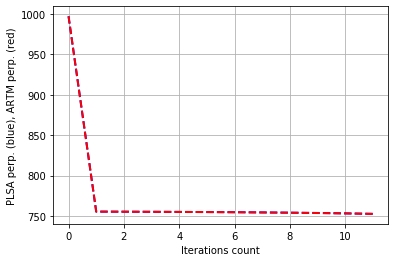

In [ ]:
print_measures(plsa_model, artm_model)

In [ ]:
artm_model.regularizers['SparsePhi'].tau = -0.2
artm_model.regularizers['SparseTheta'].tau = -0.2
artm_model.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [ ]:
plsa_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
artm_model.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

In [ ]:
plsa_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=25)

Sparsity Phi: 0.000 (PLSA) vs. 0.051 (ARTM)
Sparsity Theta: 0.000 (PLSA) vs. 0.001 (ARTM)
Kernel contrast: 0.499 (PLSA) vs. 0.501 (ARTM)
Kernel purity: 0.298 (PLSA) vs. 0.308 (ARTM)
Perplexity: 685.903 (PLSA) vs. 684.458 (ARTM)


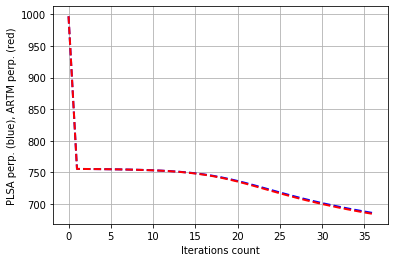

In [ ]:
print_measures(plsa_model, artm_model)

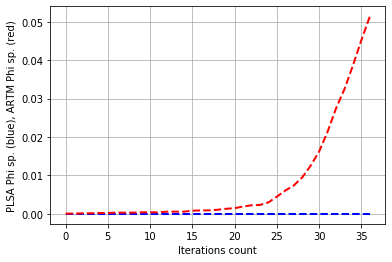

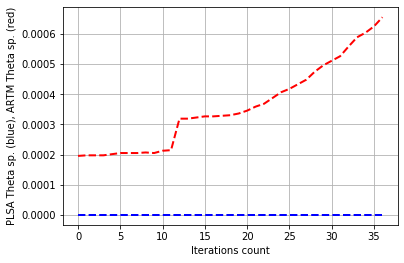

In [ ]:
plt.plot(range(plsa_model.num_phi_updates), plsa_model.score_tracker['SparsityPhiScore'].value, 'b--',
                 range(artm_model.num_phi_updates), artm_model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Phi sp. (blue), ARTM Phi sp. (red)')
plt.grid(True)
plt.show()

plt.plot(range(plsa_model.num_phi_updates), plsa_model.score_tracker['SparsityThetaScore'].value, 'b--',
                 range(artm_model.num_phi_updates), artm_model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [ ]:
plsa_model_topics = []
for topic_name in plsa_model.topic_names:
    print('{0}: {1}'.format(topic_name, plsa_model.score_tracker['TopTokensScore'].last_tokens[topic_name]))
    plsa_model_topics.append(plsa_model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['сервер', 'объект', 'необходим', 'тип', 'модул', 'сет', 'настройк', 'случа', 'пакет', 'метод']
topic_1: ['компан', 'год', 'продукт', 'клиент', 'сервис', 'сайт', 'сотрудник', 'цен', 'технолог', 'бизнес']
topic_2: ['прост', 'сдела', 'нужн', 'человек', 'вопрос', 'проект', 'задач', 'кажд', 'очен', 'част']
topic_3: ['больш', 'очен', 'перв', 'интересн', 'виде', 'люд', 'врем', 'карт', 'модел', 'час']
topic_4: ['нов', 'нужн', 'возможн', 'поэт', 'случа', 'очен', 'стат', 'адрес', 'перв', 'част']
topic_5: ['прост', 'дела', 'могут', 'кажд', 'част', 'случа', 'такж', 'должн', 'задач', 'процесс']
topic_6: ['функц', 'использова', 'значен', 'использ', 'след', 'использован', 'библиотек', 'элемент', 'кажд', 'строк']
topic_7: ['нов', 'проект', 'перв', 'ресурс', 'ключ', 'получ', 'нужн', 'задач', 'количеств', 'систем']
topic_8: ['приложен', 'команд', 'разработк', 'разработчик', 'возможн', 'решен', 'тестирован', 'мобильн', 'позволя', 'проект']
topic_9: ['игр', 'врем', 'цел', 'люд', 'игрок', 'дела',

In [ ]:
artm_model_topics = []
for topic_name in artm_model.topic_names:
    print('{0}: {1}'.format(topic_name, artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name]))
    artm_model_topics.append(artm_model.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: ['сервер', 'объект', 'необходим', 'тип', 'модул', 'сет', 'настройк', 'случа', 'пакет', 'метод']
topic_1: ['компан', 'год', 'продукт', 'клиент', 'сервис', 'сайт', 'сотрудник', 'цен', 'технолог', 'бизнес']
topic_2: ['прост', 'сдела', 'нужн', 'человек', 'вопрос', 'проект', 'задач', 'кажд', 'очен', 'част']
topic_3: ['больш', 'очен', 'перв', 'интересн', 'виде', 'люд', 'врем', 'карт', 'модел', 'час']
topic_4: ['нов', 'нужн', 'возможн', 'поэт', 'случа', 'очен', 'стат', 'адрес', 'перв', 'част']
topic_5: ['прост', 'дела', 'могут', 'кажд', 'част', 'случа', 'такж', 'должн', 'задач', 'процесс']
topic_6: ['функц', 'использова', 'значен', 'использ', 'след', 'использован', 'библиотек', 'элемент', 'кажд', 'строк']
topic_7: ['нов', 'проект', 'перв', 'ресурс', 'получ', 'ключ', 'нужн', 'задач', 'количеств', 'систем']
topic_8: ['приложен', 'команд', 'разработк', 'разработчик', 'возможн', 'решен', 'тестирован', 'мобильн', 'позволя', 'проект']
topic_9: ['игр', 'врем', 'цел', 'люд', 'игрок', 'дела',

----

### Scores

In [ ]:
text_clean = []
for index, row in data2[['clean_text']].iterrows():
    text_clean.append(row['clean_text'].split())

bigram = Phrases(text_clean)  # Создаем биграммы на основе корпуса
trigram = Phrases(bigram[text_clean])  # Создаем триграммы на основе корпуса

for idx in range(len(text_clean)):
    for token in bigram[text_clean[idx]]:
        if '_' in token:
            # Токен это би грамма, добавим в документ.
            text_clean[idx].append(token)
    for token in trigram[text_clean[idx]]:
        if '_' in token:
            # Токен это три грамма, добавим в документ.
            text_clean[idx].append(token)

In [ ]:
gen_dictionary = GensimDict(text_clean)
corpus = [gen_dictionary.doc2bow(doc) for doc in text_clean]

In [ ]:
#list(gen_dictionary.values())[:20]

In [ ]:
lda_model_topics

[['объект',
  'сет',
  'значен',
  'необходим',
  'модел',
  'модул',
  'метод',
  'тип',
  'кажд',
  'состоян'],
 ['компан',
  'год',
  'пользовател',
  'сайт',
  'клиент',
  'сервис',
  'продукт',
  'рынк',
  'сет',
  'цен'],
 ['нужн',
  'прост',
  'очен',
  'сдела',
  'человек',
  'вопрос',
  'люд',
  'задач',
  'нов',
  'дела'],
 ['очен',
  'больш',
  'модел',
  'врем',
  'прост',
  'перв',
  'камер',
  'част',
  'виде',
  'час'],
 ['код',
  'памят',
  'адрес',
  'верс',
  'программ',
  'пакет',
  'сообщен',
  'процессор',
  'устройств',
  'ядр'],
 ['случа',
  'прост',
  'тип',
  'процесс',
  'могут',
  'явля',
  'дела',
  'должн',
  'задач',
  'решен'],
 ['функц',
  'значен',
  'использова',
  'элемент',
  'строк',
  'библиотек',
  'перемен',
  'использ',
  'код',
  'след'],
 ['сервер',
  'запрос',
  'сервис',
  'клиент',
  'ключ',
  'баз',
  'нужн',
  'ресурс',
  'тест',
  'систем'],
 ['приложен',
  'проект',
  'разработчик',
  'команд',
  'разработк',
  'инструмент',
  'решен',


In [ ]:
plsa_model_topics

[['сервер',
  'объект',
  'необходим',
  'тип',
  'модул',
  'сет',
  'настройк',
  'случа',
  'пакет',
  'метод'],
 ['компан',
  'год',
  'продукт',
  'клиент',
  'сервис',
  'сайт',
  'сотрудник',
  'цен',
  'технолог',
  'бизнес'],
 ['прост',
  'сдела',
  'нужн',
  'человек',
  'вопрос',
  'проект',
  'задач',
  'кажд',
  'очен',
  'част'],
 ['больш',
  'очен',
  'перв',
  'интересн',
  'виде',
  'люд',
  'врем',
  'карт',
  'модел',
  'час'],
 ['нов',
  'нужн',
  'возможн',
  'поэт',
  'случа',
  'очен',
  'стат',
  'адрес',
  'перв',
  'част'],
 ['прост',
  'дела',
  'могут',
  'кажд',
  'част',
  'случа',
  'такж',
  'должн',
  'задач',
  'процесс'],
 ['функц',
  'использова',
  'значен',
  'использ',
  'след',
  'использован',
  'библиотек',
  'элемент',
  'кажд',
  'строк'],
 ['нов',
  'проект',
  'перв',
  'ресурс',
  'ключ',
  'получ',
  'нужн',
  'задач',
  'количеств',
  'систем'],
 ['приложен',
  'команд',
  'разработк',
  'разработчик',
  'возможн',
  'решен',
  'тестиров

In [ ]:
artm_model_topics

[['сервер',
  'объект',
  'необходим',
  'тип',
  'модул',
  'сет',
  'настройк',
  'случа',
  'пакет',
  'метод'],
 ['компан',
  'год',
  'продукт',
  'клиент',
  'сервис',
  'сайт',
  'сотрудник',
  'цен',
  'технолог',
  'бизнес'],
 ['прост',
  'сдела',
  'нужн',
  'человек',
  'вопрос',
  'проект',
  'задач',
  'кажд',
  'очен',
  'част'],
 ['больш',
  'очен',
  'перв',
  'интересн',
  'виде',
  'люд',
  'врем',
  'карт',
  'модел',
  'час'],
 ['нов',
  'нужн',
  'возможн',
  'поэт',
  'случа',
  'очен',
  'стат',
  'адрес',
  'перв',
  'част'],
 ['прост',
  'дела',
  'могут',
  'кажд',
  'част',
  'случа',
  'такж',
  'должн',
  'задач',
  'процесс'],
 ['функц',
  'использова',
  'значен',
  'использ',
  'след',
  'использован',
  'библиотек',
  'элемент',
  'кажд',
  'строк'],
 ['нов',
  'проект',
  'перв',
  'ресурс',
  'получ',
  'ключ',
  'нужн',
  'задач',
  'количеств',
  'систем'],
 ['приложен',
  'команд',
  'разработк',
  'разработчик',
  'возможн',
  'решен',
  'тестиров

### LDA

In [ ]:
model_evaluation('LDA', text_clean, lda_model_topics, gen_dictionary)

LDA Scores:
UCI: 0.49
UMass: -0.88


### PLSA

In [ ]:
model_evaluation('pLSA', text_clean, plsa_model_topics, gen_dictionary)

pLSA Scores:
UCI: 0.37
UMass: -0.85


### ARTM

In [ ]:
model_evaluation('ARTM', text_clean, artm_model_topics, gen_dictionary)

ARTM Scores:
UCI: 0.37
UMass: -0.85


----

### Cloud Words Visualization

In [ ]:
topics = plsa_model.topic_names

### LDA

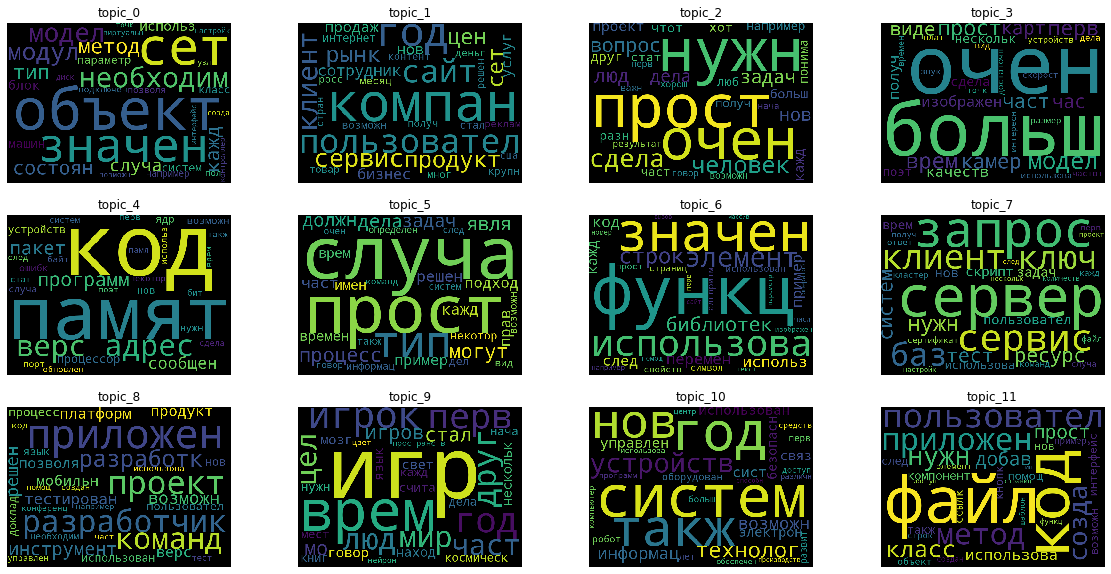

In [ ]:
plot_cloud_words(lda_model, topics, limit=30, figsize=(20,10), reverse=True)

### PLSA

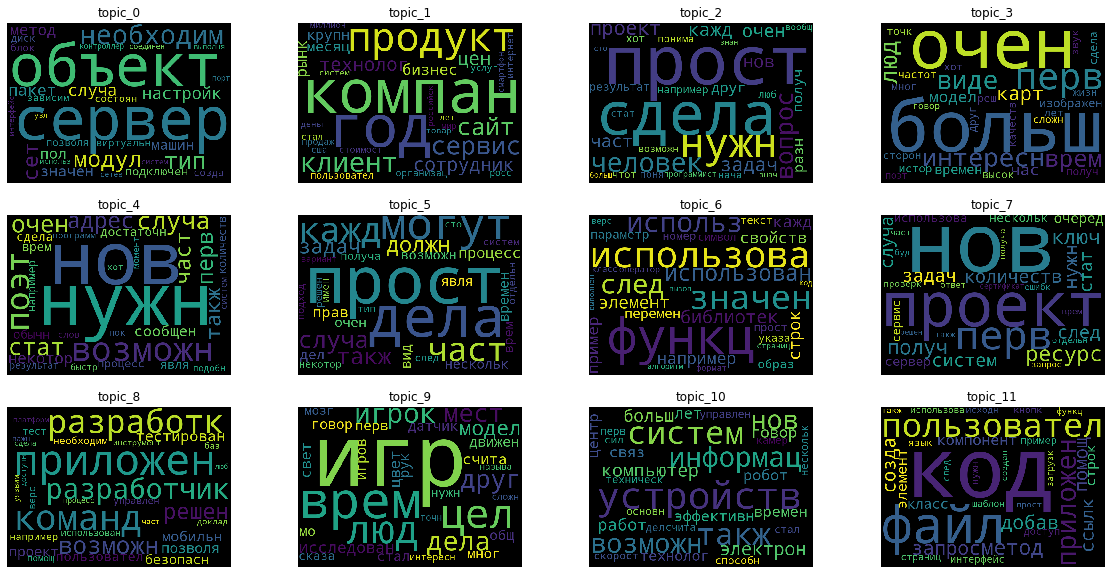

In [ ]:
plot_cloud_words(plsa_model, topics, limit=30, figsize=(20,10), reverse=True)

### ARTM

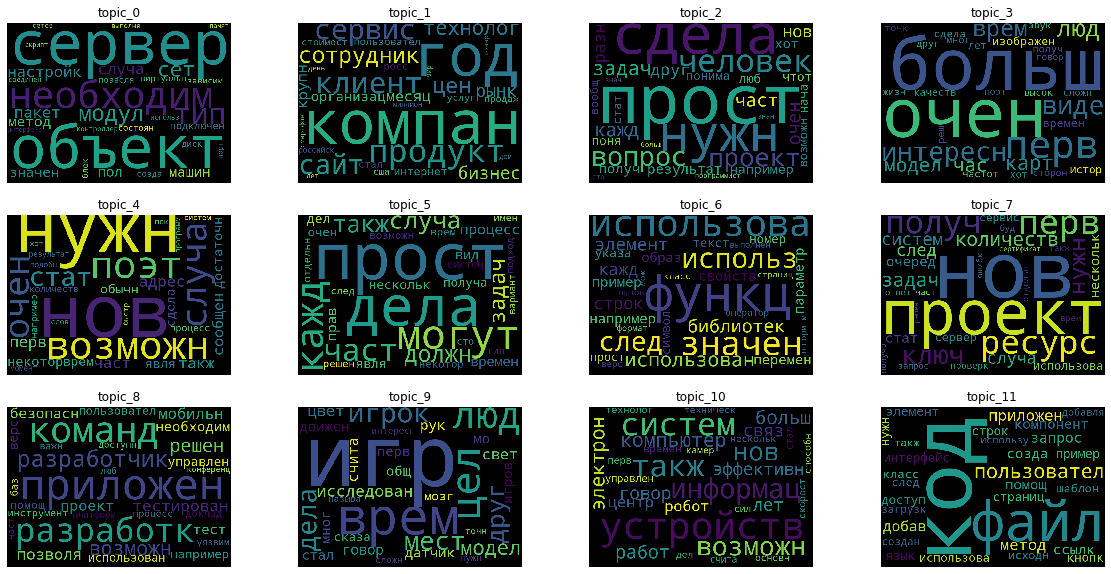

In [ ]:
plot_cloud_words(artm_model, topics, limit=30, figsize=(20,10), reverse=True)

----

### t-SNE Visualization

### LDA

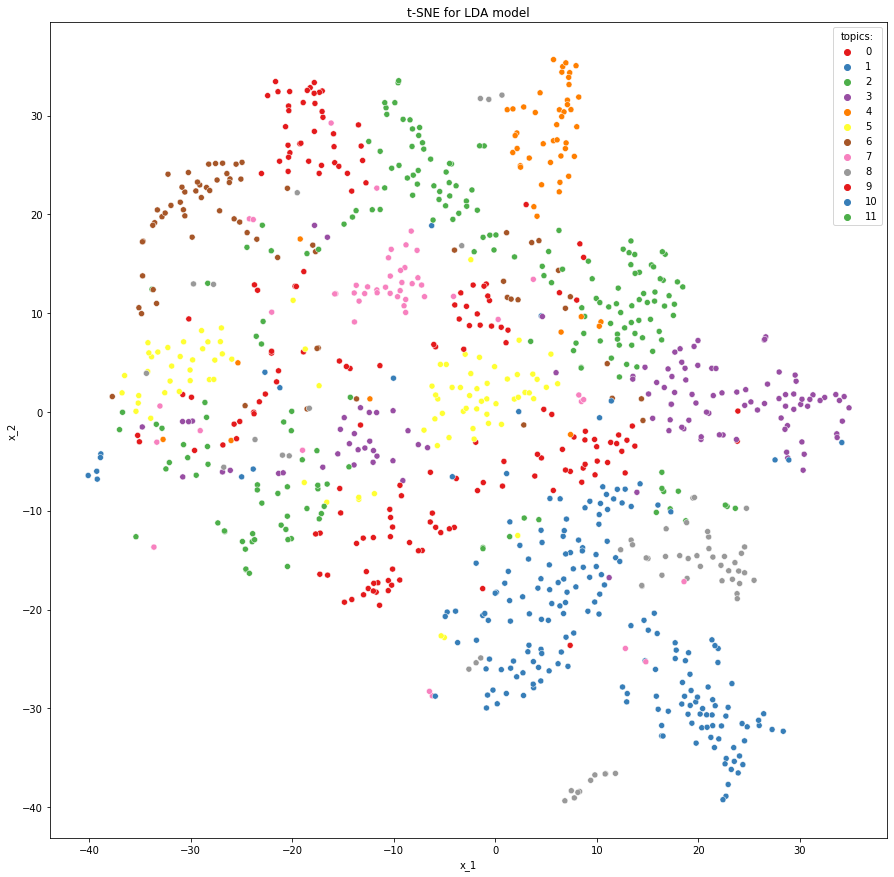

In [ ]:
tsne_vis(lda_model)

### PLSA

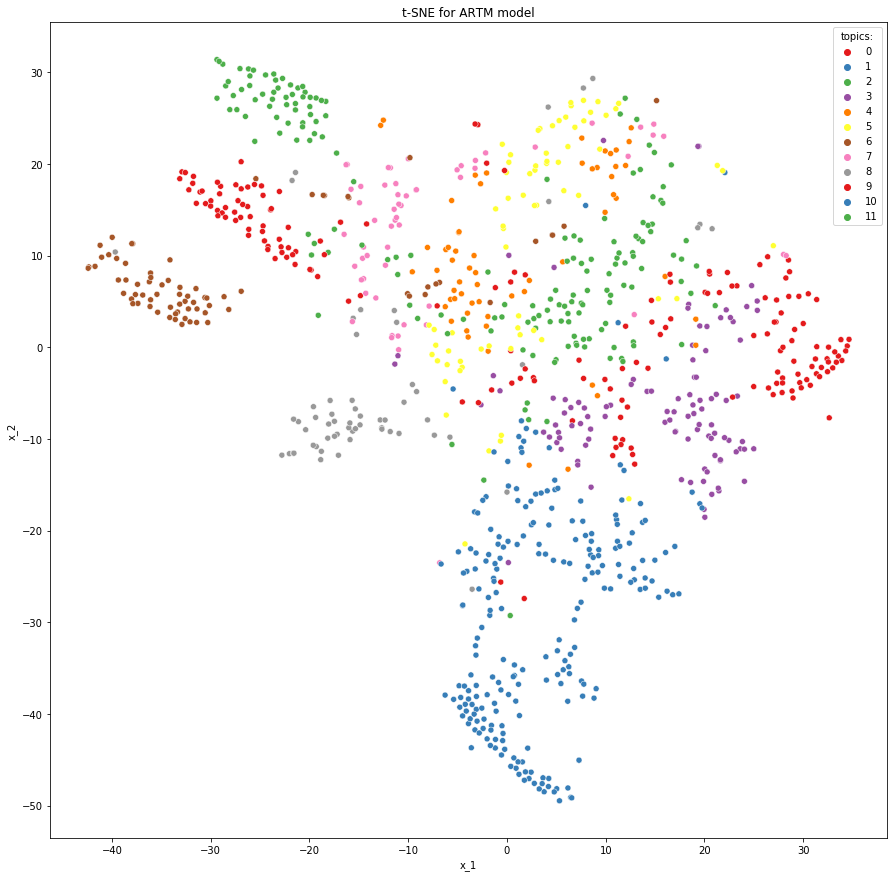

In [ ]:
tsne_vis(plsa_model)

### ARTM

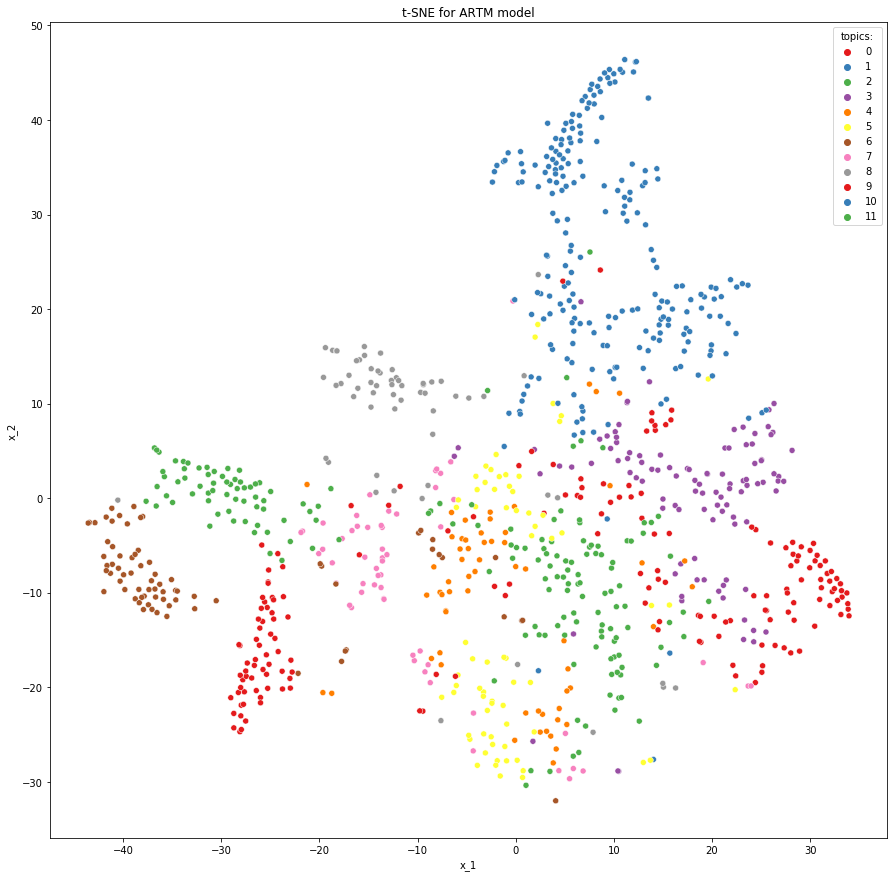

In [ ]:
tsne_vis(artm_model)

----